## Test Data Prediction
This notebook will be used to open test.csv file and use designated model to predict the test data for kaggle submission.

In [15]:
%%bash
git branch

  cost1/feat1/wip
  cost1/feat2/wip
  cost1/wip
  feat1/score1/wip
  feat1/wip
  feat2/score1/wip
* feat2/wip
  feat3/wip
  feat4/wip
  feat5/wip
  master


In [16]:
%%bash
git add 'Test_data.ipynb'
git commit -m 'Branched to feat2'
git push --set-upstream origin feat2/wip

[feat2/wip 3ffeab2] Branched to feat2
 1 file changed, 626 insertions(+)
 create mode 100644 Test_data.ipynb
Branch feat2/wip set up to track remote branch feat2/wip from origin.


To github.com:Theerit/Kaggle_Titanic.git
   a46914f..3ffeab2  feat2/wip -> feat2/wip


In [2]:
model_ver = 'feat2.sav'

In [3]:
%matplotlib inline 
import requests 
import StringIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
import seaborn as sns 

import sklearn.model_selection
import pickle

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Load data from csv file then prepare the data before inputting into the trained model.

In [23]:
test_ex = pd.read_csv('gender_submission.csv')
test_ex.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [24]:
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Bar plot to visualize data in test set

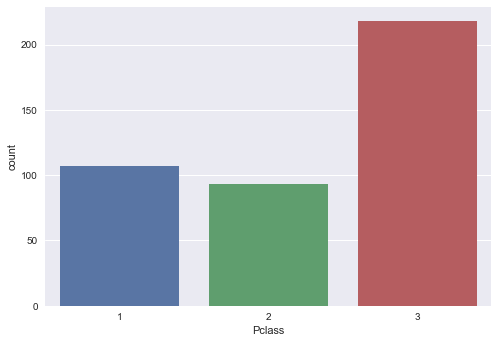

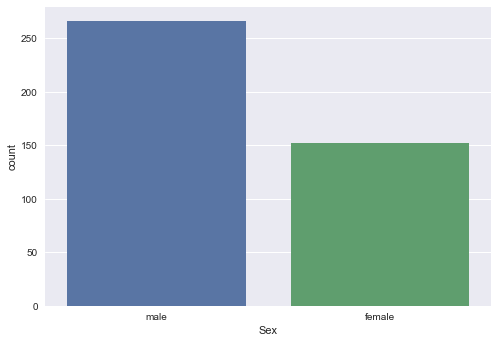

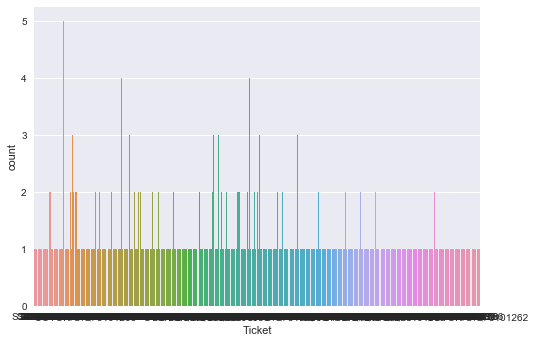

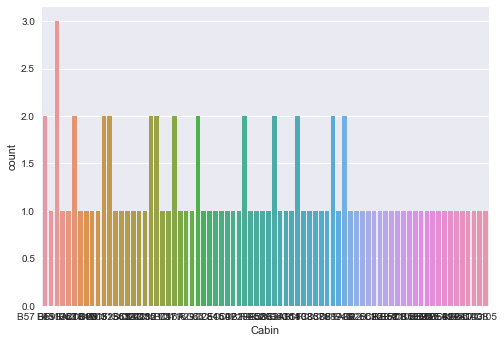

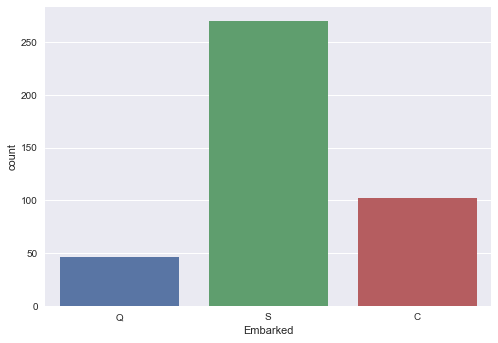

In [25]:
for i,column in enumerate(cat_attri):
    #Lets just keep every categorical attributes for plotting
    plt.figure(i)
    sns.countplot(test[column])

In [19]:
test = test.drop('PassengerId',axis=1)
test = test.drop('Name',axis=1)

#To flag num attri features
num_attri = ['Age','SibSp','Parch','Fare']
cat_attri = [column for column in test if (column not in num_attri and column != 'Survived')]

#Creating dummy variable
for column in (cat_attri):
    #Lets just keep every categorical attributes for plotting
    tempDF = pd.get_dummies(test[column],prefix=column)
    test.drop(column,axis=1,inplace=True)
    test = test.join(tempDF)
test.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Ticket_110469,...,Cabin_F E46,Cabin_F E57,Cabin_F G63,Cabin_F2,Cabin_F33,Cabin_F4,Cabin_G6,Embarked_C,Embarked_Q,Embarked_S
0,34.5,0,0,7.8292,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,47.0,1,0,7.0000,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,62.0,0,0,9.6875,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,27.0,0,0,8.6625,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,22.0,1,1,12.2875,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [36]:
loaded_model = pickle.load(open(model_ver, 'rb'))
loaded_model.predict(test)

ValueError: feature_names mismatch: [u'Age', u'SibSp', u'Parch', u'Fare', u'Pclass_1', u'Pclass_2', u'Pclass_3', u'Sex_female', u'Sex_male', u'Ticket_110152', u'Ticket_110413', u'Ticket_110465', u'Ticket_110564', u'Ticket_110813', u'Ticket_111240', u'Ticket_111320', u'Ticket_111361', u'Ticket_111369', u'Ticket_111426', u'Ticket_111427', u'Ticket_111428', u'Ticket_112050', u'Ticket_112052', u'Ticket_112053', u'Ticket_112058', u'Ticket_112059', u'Ticket_112277', u'Ticket_112379', u'Ticket_113028', u'Ticket_113043', u'Ticket_113050', u'Ticket_113051', u'Ticket_113055', u'Ticket_113056', u'Ticket_113059', u'Ticket_113501', u'Ticket_113503', u'Ticket_113505', u'Ticket_113509', u'Ticket_113510', u'Ticket_113514', u'Ticket_113572', u'Ticket_113760', u'Ticket_113767', u'Ticket_113773', u'Ticket_113776', u'Ticket_113781', u'Ticket_113783', u'Ticket_113784', u'Ticket_113786', u'Ticket_113787', u'Ticket_113788', u'Ticket_113789', u'Ticket_113792', u'Ticket_113794', u'Ticket_113796', u'Ticket_113798', u'Ticket_113800', u'Ticket_113803', u'Ticket_113804', u'Ticket_113806', u'Ticket_113807', u'Ticket_11668', u'Ticket_11751', u'Ticket_11752', u'Ticket_11753', u'Ticket_11755', u'Ticket_11765', u'Ticket_11767', u'Ticket_11769', u'Ticket_11771', u'Ticket_11774', u'Ticket_11813', u'Ticket_11967', u'Ticket_12233', u'Ticket_12460', u'Ticket_12749', u'Ticket_13049', u'Ticket_13213', u'Ticket_13214', u'Ticket_13502', u'Ticket_13507', u'Ticket_13509', u'Ticket_13567', u'Ticket_13568', u'Ticket_14311', u'Ticket_14312', u'Ticket_14313', u'Ticket_14973', u'Ticket_1601', u'Ticket_16966', u'Ticket_16988', u'Ticket_17421', u'Ticket_17453', u'Ticket_17463', u'Ticket_17464', u'Ticket_17465', u'Ticket_17466', u'Ticket_17474', u'Ticket_17764', u'Ticket_19877', u'Ticket_19928', u'Ticket_19943', u'Ticket_19947', u'Ticket_19950', u'Ticket_19952', u'Ticket_19972', u'Ticket_19988', u'Ticket_19996', u'Ticket_2003', u'Ticket_211536', u'Ticket_21440', u'Ticket_218629', u'Ticket_219533', u'Ticket_220367', u'Ticket_220845', u'Ticket_2223', u'Ticket_223596', u'Ticket_226593', u'Ticket_226875', u'Ticket_228414', u'Ticket_229236', u'Ticket_230080', u'Ticket_230136', u'Ticket_230433', u'Ticket_230434', u'Ticket_231919', u'Ticket_231945', u'Ticket_233639', u'Ticket_233866', u'Ticket_234360', u'Ticket_234604', u'Ticket_234686', u'Ticket_234818', u'Ticket_236171', u'Ticket_236852', u'Ticket_236853', u'Ticket_237442', u'Ticket_237565', u'Ticket_237668', u'Ticket_237671', u'Ticket_237736', u'Ticket_237789', u'Ticket_237798', u'Ticket_239853', u'Ticket_239854', u'Ticket_239855', u'Ticket_239856', u'Ticket_239865', u'Ticket_240929', u'Ticket_24160', u'Ticket_243847', u'Ticket_243880', u'Ticket_244252', u'Ticket_244270', u'Ticket_244278', u'Ticket_244310', u'Ticket_244358', u'Ticket_244361', u'Ticket_244367', u'Ticket_244373', u'Ticket_248698', u'Ticket_248706', u'Ticket_248723', u'Ticket_248727', u'Ticket_248731', u'Ticket_248733', u'Ticket_248738', u'Ticket_248740', u'Ticket_248747', u'Ticket_250643', u'Ticket_250644', u'Ticket_250646', u'Ticket_250647', u'Ticket_250648', u'Ticket_250649', u'Ticket_250651', u'Ticket_250652', u'Ticket_250653', u'Ticket_250655', u'Ticket_2620', u'Ticket_2623', u'Ticket_2624', u'Ticket_2625', u'Ticket_2626', u'Ticket_2627', u'Ticket_2628', u'Ticket_2629', u'Ticket_2631', u'Ticket_26360', u'Ticket_2641', u'Ticket_2647', u'Ticket_2648', u'Ticket_2649', u'Ticket_2650', u'Ticket_2651', u'Ticket_2653', u'Ticket_2659', u'Ticket_2661', u'Ticket_2662', u'Ticket_2663', u'Ticket_2664', u'Ticket_2665', u'Ticket_2666', u'Ticket_2667', u'Ticket_2668', u'Ticket_2669', u'Ticket_26707', u'Ticket_2671', u'Ticket_2672', u'Ticket_2674', u'Ticket_2677', u'Ticket_2678', u'Ticket_2680', u'Ticket_2683', u'Ticket_2685', u'Ticket_2686', u'Ticket_2687', u'Ticket_2689', u'Ticket_2690', u'Ticket_2691', u'Ticket_2693', u'Ticket_2694', u'Ticket_2695', u'Ticket_2697', u'Ticket_2699', u'Ticket_2700', u'Ticket_27042', u'Ticket_27267', u'Ticket_27849', u'Ticket_28134', u'Ticket_28206', u'Ticket_28213', u'Ticket_28220', u'Ticket_28228', u'Ticket_28403', u'Ticket_28424', u'Ticket_28425', u'Ticket_28551', u'Ticket_28664', u'Ticket_28665', u'Ticket_29011', u'Ticket_2908', u'Ticket_29103', u'Ticket_29104', u'Ticket_29105', u'Ticket_29106', u'Ticket_29108', u'Ticket_2926', u'Ticket_29750', u'Ticket_29751', u'Ticket_3101264', u'Ticket_3101265', u'Ticket_3101267', u'Ticket_3101276', u'Ticket_3101277', u'Ticket_3101278', u'Ticket_3101281', u'Ticket_3101295', u'Ticket_3101296', u'Ticket_3101298', u'Ticket_31027', u'Ticket_31028', u'Ticket_312991', u'Ticket_312992', u'Ticket_312993', u'Ticket_31418', u'Ticket_315037', u'Ticket_315082', u'Ticket_315084', u'Ticket_315086', u'Ticket_315088', u'Ticket_315089', u'Ticket_315090', u'Ticket_315093', u'Ticket_315094', u'Ticket_315096', u'Ticket_315097', u'Ticket_315098', u'Ticket_315151', u'Ticket_315153', u'Ticket_323592', u'Ticket_323951', u'Ticket_324669', u'Ticket_330877', u'Ticket_330909', u'Ticket_330919', u'Ticket_330923', u'Ticket_330931', u'Ticket_330932', u'Ticket_330935', u'Ticket_330958', u'Ticket_330959', u'Ticket_330979', u'Ticket_330980', u'Ticket_334912', u'Ticket_335097', u'Ticket_335677', u'Ticket_33638', u'Ticket_336439', u'Ticket_3411', u'Ticket_341826', u'Ticket_34218', u'Ticket_342826', u'Ticket_343095', u'Ticket_343120', u'Ticket_343275', u'Ticket_343276', u'Ticket_345364', u'Ticket_345572', u'Ticket_345763', u'Ticket_345764', u'Ticket_345765', u'Ticket_345767', u'Ticket_345769', u'Ticket_345770', u'Ticket_345773', u'Ticket_345774', u'Ticket_345777', u'Ticket_345778', u'Ticket_345779', u'Ticket_345780', u'Ticket_345781', u'Ticket_345783', u'Ticket_3460', u'Ticket_347054', u'Ticket_347060', u'Ticket_347061', u'Ticket_347062', u'Ticket_347063', u'Ticket_347064', u'Ticket_347067', u'Ticket_347068', u'Ticket_347069', u'Ticket_347071', u'Ticket_347073', u'Ticket_347074', u'Ticket_347076', u'Ticket_347077', u'Ticket_347078', u'Ticket_347080', u'Ticket_347081', u'Ticket_347082', u'Ticket_347083', u'Ticket_347085', u'Ticket_347087', u'Ticket_347088', u'Ticket_347089', u'Ticket_3474', u'Ticket_347464', u'Ticket_347466', u'Ticket_347468', u'Ticket_347470', u'Ticket_347742', u'Ticket_347743', u'Ticket_348121', u'Ticket_348123', u'Ticket_348124', u'Ticket_349201', u'Ticket_349203', u'Ticket_349204', u'Ticket_349205', u'Ticket_349206', u'Ticket_349207', u'Ticket_349208', u'Ticket_349209', u'Ticket_349210', u'Ticket_349212', u'Ticket_349213', u'Ticket_349214', u'Ticket_349215', u'Ticket_349216', u'Ticket_349217', u'Ticket_349218', u'Ticket_349219', u'Ticket_349221', u'Ticket_349222', u'Ticket_349223', u'Ticket_349224', u'Ticket_349225', u'Ticket_349227', u'Ticket_349228', u'Ticket_349231', u'Ticket_349233', u'Ticket_349234', u'Ticket_349236', u'Ticket_349237', u'Ticket_349239', u'Ticket_349240', u'Ticket_349241', u'Ticket_349242', u'Ticket_349243', u'Ticket_349244', u'Ticket_349245', u'Ticket_349246', u'Ticket_349247', u'Ticket_349248', u'Ticket_349249', u'Ticket_349251', u'Ticket_349252', u'Ticket_349253', u'Ticket_349254', u'Ticket_349256', u'Ticket_349257', u'Ticket_349909', u'Ticket_349910', u'Ticket_349912', u'Ticket_350025', u'Ticket_350026', u'Ticket_350029', u'Ticket_350034', u'Ticket_350035', u'Ticket_350036', u'Ticket_350042', u'Ticket_350043', u'Ticket_350046', u'Ticket_350047', u'Ticket_350048', u'Ticket_350050', u'Ticket_350052', u'Ticket_350060', u'Ticket_350404', u'Ticket_350406', u'Ticket_350407', u'Ticket_350417', u'Ticket_35273', u'Ticket_35281', u'Ticket_35851', u'Ticket_35852', u'Ticket_358585', u'Ticket_36209', u'Ticket_362316', u'Ticket_363291', u'Ticket_363294', u'Ticket_363592', u'Ticket_364498', u'Ticket_364499', u'Ticket_364500', u'Ticket_364506', u'Ticket_364511', u'Ticket_364512', u'Ticket_364516', u'Ticket_364846', u'Ticket_364848', u'Ticket_364849', u'Ticket_364850', u'Ticket_364851', u'Ticket_365222', u'Ticket_365226', u'Ticket_36568', u'Ticket_367226', u'Ticket_367228', u'Ticket_367229', u'Ticket_367230', u'Ticket_367231', u'Ticket_367232', u'Ticket_367655', u'Ticket_368323', u'Ticket_36864', u'Ticket_36865', u'Ticket_36866', u'Ticket_368703', u'Ticket_36928', u'Ticket_36947', u'Ticket_36963', u'Ticket_36967', u'Ticket_36973', u'Ticket_370129', u'Ticket_370365', u'Ticket_370369', u'Ticket_370370', u'Ticket_370371', u'Ticket_370372', u'Ticket_370373', u'Ticket_370375', u'Ticket_370376', u'Ticket_370377', u'Ticket_371060', u'Ticket_371110', u'Ticket_371362', u'Ticket_372622', u'Ticket_373450', u'Ticket_374746', u'Ticket_374887', u'Ticket_374910', u'Ticket_376564', u'Ticket_376566', u'Ticket_382649', u'Ticket_382651', u'Ticket_382652', u'Ticket_383121', u'Ticket_384461', u'Ticket_386525', u'Ticket_392091', u'Ticket_392092', u'Ticket_392096', u'Ticket_394140', u'Ticket_4133', u'Ticket_4134', u'Ticket_4135', u'Ticket_4136', u'Ticket_4137', u'Ticket_4138', u'Ticket_4579', u'Ticket_54636', u'Ticket_5727', u'Ticket_65303', u'Ticket_65304', u'Ticket_65306', u'Ticket_6563', u'Ticket_693', u'Ticket_695', u'Ticket_7267', u'Ticket_7534', u'Ticket_7540', u'Ticket_7545', u'Ticket_7546', u'Ticket_7552', u'Ticket_7553', u'Ticket_7598', u'Ticket_8471', u'Ticket_8475', u'Ticket_9234', u'Ticket_A./5. 2152', u'Ticket_A./5. 3235', u'Ticket_A.5. 11206', u'Ticket_A.5. 18509', u'Ticket_A/4 45380', u'Ticket_A/4 48871', u'Ticket_A/4. 20589', u'Ticket_A/4. 34244', u'Ticket_A/4. 39886', u'Ticket_A/5 21171', u'Ticket_A/5 21172', u'Ticket_A/5 21173', u'Ticket_A/5 21174', u'Ticket_A/5 2466', u'Ticket_A/5 2817', u'Ticket_A/5 3536', u'Ticket_A/5 3540', u'Ticket_A/5 3594', u'Ticket_A/5 3902', u'Ticket_A/5. 10482', u'Ticket_A/5. 13032', u'Ticket_A/5. 2151', u'Ticket_A/5. 3336', u'Ticket_A/5. 3337', u'Ticket_A/5. 851', u'Ticket_A/S 2816', u'Ticket_A4. 54510', u'Ticket_C 17369', u'Ticket_C 4001', u'Ticket_C 7075', u'Ticket_C 7076', u'Ticket_C 7077', u'Ticket_C.A. 17248', u'Ticket_C.A. 18723', u'Ticket_C.A. 2315', u'Ticket_C.A. 24579', u'Ticket_C.A. 24580', u'Ticket_C.A. 2673', u'Ticket_C.A. 29178', u'Ticket_C.A. 29395', u'Ticket_C.A. 29566', u'Ticket_C.A. 31026', u'Ticket_C.A. 31921', u'Ticket_C.A. 33111', u'Ticket_C.A. 33112', u'Ticket_C.A. 33595', u'Ticket_C.A. 34260', u'Ticket_C.A. 34651', u'Ticket_C.A. 37671', u'Ticket_C.A. 5547', u'Ticket_C.A. 6212', u'Ticket_C.A./SOTON 34068', u'Ticket_CA 2144', u'Ticket_CA. 2314', u'Ticket_CA. 2343', u'Ticket_F.C. 12750', u'Ticket_F.C.C. 13528', u'Ticket_F.C.C. 13529', u'Ticket_F.C.C. 13531', u'Ticket_Fa 265302', u'Ticket_LINE', u'Ticket_P/PP 3381', u'Ticket_PC 17318', u'Ticket_PC 17473', u'Ticket_PC 17474', u'Ticket_PC 17475', u'Ticket_PC 17476', u'Ticket_PC 17477', u'Ticket_PC 17482', u'Ticket_PC 17483', u'Ticket_PC 17485', u'Ticket_PC 17558', u'Ticket_PC 17569', u'Ticket_PC 17572', u'Ticket_PC 17582', u'Ticket_PC 17585', u'Ticket_PC 17590', u'Ticket_PC 17592', u'Ticket_PC 17593', u'Ticket_PC 17595', u'Ticket_PC 17596', u'Ticket_PC 17597', u'Ticket_PC 17599', u'Ticket_PC 17600', u'Ticket_PC 17601', u'Ticket_PC 17603', u'Ticket_PC 17604', u'Ticket_PC 17605', u'Ticket_PC 17608', u'Ticket_PC 17609', u'Ticket_PC 17610', u'Ticket_PC 17611', u'Ticket_PC 17612', u'Ticket_PC 17754', u'Ticket_PC 17755', u'Ticket_PC 17756', u'Ticket_PC 17757', u'Ticket_PC 17758', u'Ticket_PC 17759', u'Ticket_PC 17760', u'Ticket_PC 17761', u'Ticket_PP 4348', u'Ticket_PP 9549', u'Ticket_S.C./A.4. 23567', u'Ticket_S.C./PARIS 2079', u'Ticket_S.O./P.P. 3', u'Ticket_S.O./P.P. 751', u'Ticket_S.O.C. 14879', u'Ticket_S.O.P. 1166', u'Ticket_S.P. 3464', u'Ticket_S.W./PP 752', u'Ticket_SC 1748', u'Ticket_SC/AH 29037', u'Ticket_SC/AH 3085', u'Ticket_SC/AH Basle 541', u'Ticket_SC/PARIS 2131', u'Ticket_SC/PARIS 2133', u'Ticket_SC/PARIS 2146', u'Ticket_SC/PARIS 2149', u'Ticket_SC/PARIS 2167', u'Ticket_SC/Paris 2123', u'Ticket_SC/Paris 2163', u'Ticket_SCO/W 1585', u'Ticket_SO/C 14885', u'Ticket_SOTON/O.Q. 3101305', u'Ticket_SOTON/O.Q. 3101306', u'Ticket_SOTON/O.Q. 3101307', u'Ticket_SOTON/O.Q. 3101310', u'Ticket_SOTON/O.Q. 3101311', u'Ticket_SOTON/O.Q. 3101312', u'Ticket_SOTON/O.Q. 392078', u'Ticket_SOTON/O.Q. 392087', u'Ticket_SOTON/O2 3101272', u'Ticket_SOTON/O2 3101287', u'Ticket_SOTON/OQ 3101316', u'Ticket_SOTON/OQ 3101317', u'Ticket_SOTON/OQ 392076', u'Ticket_SOTON/OQ 392082', u'Ticket_SOTON/OQ 392086', u'Ticket_SOTON/OQ 392089', u'Ticket_SOTON/OQ 392090', u'Ticket_STON/O 2. 3101269', u'Ticket_STON/O 2. 3101273', u'Ticket_STON/O 2. 3101274', u'Ticket_STON/O 2. 3101275', u'Ticket_STON/O 2. 3101280', u'Ticket_STON/O 2. 3101285', u'Ticket_STON/O 2. 3101286', u'Ticket_STON/O 2. 3101288', u'Ticket_STON/O 2. 3101289', u'Ticket_STON/O 2. 3101292', u'Ticket_STON/O 2. 3101293', u'Ticket_STON/O 2. 3101294', u'Ticket_STON/O2. 3101271', u'Ticket_STON/O2. 3101279', u'Ticket_STON/O2. 3101282', u'Ticket_STON/O2. 3101283', u'Ticket_STON/O2. 3101290', u'Ticket_SW/PP 751', u'Ticket_W./C. 14258', u'Ticket_W./C. 14263', u'Ticket_W./C. 6607', u'Ticket_W./C. 6608', u'Ticket_W./C. 6609', u'Ticket_W.E.P. 5734', u'Ticket_W/C 14208', u'Ticket_WE/P 5735', u'Cabin_A10', u'Cabin_A14', u'Cabin_A16', u'Cabin_A19', u'Cabin_A20', u'Cabin_A23', u'Cabin_A24', u'Cabin_A26', u'Cabin_A31', u'Cabin_A32', u'Cabin_A34', u'Cabin_A36', u'Cabin_A5', u'Cabin_A6', u'Cabin_A7', u'Cabin_B101', u'Cabin_B102', u'Cabin_B18', u'Cabin_B19', u'Cabin_B20', u'Cabin_B22', u'Cabin_B28', u'Cabin_B3', u'Cabin_B30', u'Cabin_B35', u'Cabin_B37', u'Cabin_B38', u'Cabin_B39', u'Cabin_B4', u'Cabin_B41', u'Cabin_B42', u'Cabin_B49', u'Cabin_B5', u'Cabin_B50', u'Cabin_B51 B53 B55', u'Cabin_B57 B59 B63 B66', u'Cabin_B58 B60', u'Cabin_B69', u'Cabin_B71', u'Cabin_B73', u'Cabin_B77', u'Cabin_B78', u'Cabin_B79', u'Cabin_B80', u'Cabin_B82 B84', u'Cabin_B86', u'Cabin_B94', u'Cabin_B96 B98', u'Cabin_C101', u'Cabin_C103', u'Cabin_C104', u'Cabin_C106', u'Cabin_C110', u'Cabin_C111', u'Cabin_C118', u'Cabin_C123', u'Cabin_C124', u'Cabin_C125', u'Cabin_C126', u'Cabin_C128', u'Cabin_C148', u'Cabin_C2', u'Cabin_C22 C26', u'Cabin_C23 C25 C27', u'Cabin_C30', u'Cabin_C32', u'Cabin_C45', u'Cabin_C46', u'Cabin_C47', u'Cabin_C49', u'Cabin_C50', u'Cabin_C52', u'Cabin_C54', u'Cabin_C62 C64', u'Cabin_C65', u'Cabin_C68', u'Cabin_C7', u'Cabin_C70', u'Cabin_C78', u'Cabin_C82', u'Cabin_C83', u'Cabin_C85', u'Cabin_C86', u'Cabin_C87', u'Cabin_C90', u'Cabin_C91', u'Cabin_C92', u'Cabin_C93', u'Cabin_C95', u'Cabin_C99', u'Cabin_D', u'Cabin_D10 D12', u'Cabin_D11', u'Cabin_D15', u'Cabin_D17', u'Cabin_D19', u'Cabin_D20', u'Cabin_D21', u'Cabin_D26', u'Cabin_D28', u'Cabin_D30', u'Cabin_D33', u'Cabin_D35', u'Cabin_D36', u'Cabin_D37', u'Cabin_D45', u'Cabin_D46', u'Cabin_D47', u'Cabin_D48', u'Cabin_D49', u'Cabin_D50', u'Cabin_D56', u'Cabin_D6', u'Cabin_D7', u'Cabin_D9', u'Cabin_E10', u'Cabin_E101', u'Cabin_E12', u'Cabin_E121', u'Cabin_E17', u'Cabin_E24', u'Cabin_E25', u'Cabin_E31', u'Cabin_E33', u'Cabin_E34', u'Cabin_E36', u'Cabin_E38', u'Cabin_E40', u'Cabin_E44', u'Cabin_E46', u'Cabin_E49', u'Cabin_E50', u'Cabin_E58', u'Cabin_E63', u'Cabin_E67', u'Cabin_E68', u'Cabin_E77', u'Cabin_E8', u'Cabin_F E69', u'Cabin_F G63', u'Cabin_F G73', u'Cabin_F2', u'Cabin_F33', u'Cabin_F38', u'Cabin_F4', u'Cabin_G6', u'Cabin_T', u'Embarked_C', u'Embarked_Q', u'Embarked_S'] [u'Age', u'SibSp', u'Parch', u'Fare', u'Pclass_1', u'Pclass_2', u'Pclass_3', u'Sex_female', u'Sex_male', u'Ticket_110469', u'Ticket_110489', u'Ticket_110813', u'Ticket_111163', u'Ticket_112051', u'Ticket_112058', u'Ticket_112377', u'Ticket_112378', u'Ticket_112901', u'Ticket_113038', u'Ticket_113044', u'Ticket_113054', u'Ticket_113059', u'Ticket_113503', u'Ticket_113509', u'Ticket_113773', u'Ticket_113778', u'Ticket_113780', u'Ticket_113781', u'Ticket_113790', u'Ticket_113791', u'Ticket_113795', u'Ticket_113796', u'Ticket_113801', u'Ticket_11753', u'Ticket_11765', u'Ticket_11767', u'Ticket_11769', u'Ticket_11770', u'Ticket_11778', u'Ticket_11813', u'Ticket_1222', u'Ticket_12749', u'Ticket_13050', u'Ticket_13236', u'Ticket_13508', u'Ticket_13567', u'Ticket_13695', u'Ticket_13905', u'Ticket_1601', u'Ticket_16966', u'Ticket_17463', u'Ticket_17464', u'Ticket_17475', u'Ticket_17765', u'Ticket_17770', u'Ticket_19877', u'Ticket_19924', u'Ticket_19928', u'Ticket_19950', u'Ticket_2003', u'Ticket_211535', u'Ticket_21228', u'Ticket_21332', u'Ticket_220844', u'Ticket_220845', u'Ticket_226875', u'Ticket_228414', u'Ticket_230136', u'Ticket_233478', u'Ticket_233734', u'Ticket_235509', u'Ticket_236853', u'Ticket_236854', u'Ticket_237216', u'Ticket_237249', u'Ticket_237393', u'Ticket_237670', u'Ticket_237734', u'Ticket_237735', u'Ticket_237789', u'Ticket_239059', u'Ticket_240261', u'Ticket_240276', u'Ticket_24065', u'Ticket_24160', u'Ticket_242963', u'Ticket_244346', u'Ticket_244358', u'Ticket_244360', u'Ticket_244368', u'Ticket_248659', u'Ticket_248726', u'Ticket_248734', u'Ticket_248738', u'Ticket_248744', u'Ticket_248746', u'Ticket_250650', u'Ticket_250651', u'Ticket_2543', u'Ticket_2621', u'Ticket_2622', u'Ticket_2625', u'Ticket_26360', u'Ticket_2650', u'Ticket_2652', u'Ticket_2653', u'Ticket_2654', u'Ticket_2655', u'Ticket_2656', u'Ticket_2657', u'Ticket_2658', u'Ticket_2660', u'Ticket_2661', u'Ticket_2662', u'Ticket_2668', u'Ticket_2670', u'Ticket_26707', u'Ticket_2673', u'Ticket_2675', u'Ticket_2676', u'Ticket_2678', u'Ticket_2679', u'Ticket_2680', u'Ticket_2681', u'Ticket_2682', u'Ticket_2684', u'Ticket_2688', u'Ticket_2689', u'Ticket_2692', u'Ticket_2696', u'Ticket_2698', u'Ticket_28004', u'Ticket_28034', u'Ticket_28133', u'Ticket_28220', u'Ticket_28221', u'Ticket_28404', u'Ticket_28664', u'Ticket_28666', u'Ticket_29103', u'Ticket_29105', u'Ticket_29107', u'Ticket_2926', u'Ticket_29750', u'Ticket_3101266', u'Ticket_3101295', u'Ticket_3101297', u'Ticket_3101298', u'Ticket_315083', u'Ticket_315085', u'Ticket_315087', u'Ticket_315091', u'Ticket_315092', u'Ticket_315095', u'Ticket_315152', u'Ticket_315153', u'Ticket_315154', u'Ticket_32302', u'Ticket_329944', u'Ticket_330844', u'Ticket_330910', u'Ticket_330911', u'Ticket_330920', u'Ticket_330924', u'Ticket_330963', u'Ticket_330968', u'Ticket_330971', u'Ticket_330972', u'Ticket_334914', u'Ticket_334915', u'Ticket_335432', u'Ticket_33638', u'Ticket_3410', u'Ticket_342441', u'Ticket_342684', u'Ticket_342712', u'Ticket_343271', u'Ticket_345498', u'Ticket_345501', u'Ticket_345572', u'Ticket_345763', u'Ticket_345768', u'Ticket_345771', u'Ticket_345775', u'Ticket_3470', u'Ticket_347065', u'Ticket_347066', u'Ticket_347070', u'Ticket_347072', u'Ticket_347075', u'Ticket_347077', u'Ticket_347079', u'Ticket_347080', u'Ticket_347086', u'Ticket_347090', u'Ticket_347091', u'Ticket_347465', u'Ticket_347467', u'Ticket_347469', u'Ticket_347471', u'Ticket_348122', u'Ticket_348125', u'Ticket_349202', u'Ticket_349211', u'Ticket_349220', u'Ticket_349226', u'Ticket_349229', u'Ticket_349230', u'Ticket_349232', u'Ticket_349235', u'Ticket_349238', u'Ticket_349250', u'Ticket_349255', u'Ticket_349256', u'Ticket_349909', u'Ticket_349910', u'Ticket_349911', u'Ticket_350026', u'Ticket_350033', u'Ticket_350045', u'Ticket_350053', u'Ticket_350054', u'Ticket_350403', u'Ticket_350405', u'Ticket_350408', u'Ticket_350409', u'Ticket_350410', u'Ticket_350416', u'Ticket_359306', u'Ticket_359309', u'Ticket_363272', u'Ticket_363611', u'Ticket_364498', u'Ticket_364856', u'Ticket_364858', u'Ticket_364859', u'Ticket_365235', u'Ticket_365237', u'Ticket_36568', u'Ticket_366713', u'Ticket_367226', u'Ticket_367227', u'Ticket_368364', u'Ticket_368402', u'Ticket_368573', u'Ticket_368702', u'Ticket_368783', u'Ticket_36928', u'Ticket_3701', u'Ticket_370129', u'Ticket_370368', u'Ticket_370371', u'Ticket_370374', u'Ticket_371109', u'Ticket_371362', u'Ticket_376563', u'Ticket_376566', u'Ticket_382650', u'Ticket_382652', u'Ticket_382653', u'Ticket_383123', u'Ticket_383162', u'Ticket_386525', u'Ticket_392091', u'Ticket_392095', u'Ticket_4133', u'Ticket_65305', u'Ticket_680', u'Ticket_694', u'Ticket_7266', u'Ticket_7538', u'Ticket_7548', u'Ticket_7935', u'Ticket_9232', u'Ticket_A. 2. 39186', u'Ticket_A./5. 3338', u'Ticket_A.5. 3236', u'Ticket_A/4 31416', u'Ticket_A/4 48871', u'Ticket_A/4 48873', u'Ticket_A/5 1478', u'Ticket_A/5 21175', u'Ticket_A/5. 3337', u'Ticket_A/5. 851', u'Ticket_AQ/3. 30631', u'Ticket_AQ/4 3130', u'Ticket_C 17368', u'Ticket_C 4001', u'Ticket_C.A. 15185', u'Ticket_C.A. 2315', u'Ticket_C.A. 2673', u'Ticket_C.A. 30769', u'Ticket_C.A. 31029', u'Ticket_C.A. 31030', u'Ticket_C.A. 33112', u'Ticket_C.A. 33595', u'Ticket_C.A. 34050', u'Ticket_C.A. 34644', u'Ticket_C.A. 34651', u'Ticket_C.A. 37671', u'Ticket_C.A. 42795', u'Ticket_C.A. 49867', u'Ticket_C.A. 6212', u'Ticket_CA 2144', u'Ticket_CA 31352', u'Ticket_CA. 2343', u'Ticket_F.C. 12750', u'Ticket_F.C. 12998', u'Ticket_F.C.C. 13528', u'Ticket_F.C.C. 13534', u'Ticket_F.C.C. 13540', u'Ticket_LP 1588', u'Ticket_PC 17483', u'Ticket_PC 17531', u'Ticket_PC 17558', u'Ticket_PC 17562', u'Ticket_PC 17569', u'Ticket_PC 17580', u'Ticket_PC 17585', u'Ticket_PC 17591', u'Ticket_PC 17592', u'Ticket_PC 17594', u'Ticket_PC 17597', u'Ticket_PC 17598', u'Ticket_PC 17599', u'Ticket_PC 17603', u'Ticket_PC 17606', u'Ticket_PC 17607', u'Ticket_PC 17608', u'Ticket_PC 17613', u'Ticket_PC 17755', u'Ticket_PC 17756', u'Ticket_PC 17757', u'Ticket_PC 17758', u'Ticket_PC 17759', u'Ticket_PC 17760', u'Ticket_PC 17761', u'Ticket_PP 9549', u'Ticket_S.C./PARIS 2079', u'Ticket_S.O./P.P. 2', u'Ticket_S.O./P.P. 251', u'Ticket_S.O./P.P. 752', u'Ticket_S.O.C. 14879', u'Ticket_SC 14888', u'Ticket_SC/A.3 2861', u'Ticket_SC/A4 23568', u'Ticket_SC/AH 29037', u'Ticket_SC/AH 3085', u'Ticket_SC/PARIS 2147', u'Ticket_SC/PARIS 2148', u'Ticket_SC/PARIS 2159', u'Ticket_SC/PARIS 2166', u'Ticket_SC/PARIS 2167', u'Ticket_SC/PARIS 2168', u'Ticket_SC/Paris 2123', u'Ticket_SOTON/O.Q. 3101262', u'Ticket_SOTON/O.Q. 3101263', u'Ticket_SOTON/O.Q. 3101308', u'Ticket_SOTON/O.Q. 3101309', u'Ticket_SOTON/O.Q. 3101314', u'Ticket_SOTON/O.Q. 3101315', u'Ticket_SOTON/O2 3101284', u'Ticket_SOTON/OQ 392083', u'Ticket_STON/O 2. 3101268', u'Ticket_STON/O 2. 3101291', u'Ticket_STON/O2. 3101270', u'Ticket_STON/OQ. 369943', u'Ticket_W./C. 14260', u'Ticket_W./C. 14266', u'Ticket_W./C. 6607', u'Ticket_W./C. 6608', u'Ticket_W.E.P. 5734', u'Cabin_A11', u'Cabin_A18', u'Cabin_A21', u'Cabin_A29', u'Cabin_A34', u'Cabin_A9', u'Cabin_B10', u'Cabin_B11', u'Cabin_B24', u'Cabin_B26', u'Cabin_B36', u'Cabin_B41', u'Cabin_B45', u'Cabin_B51 B53 B55', u'Cabin_B52 B54 B56', u'Cabin_B57 B59 B63 B66', u'Cabin_B58 B60', u'Cabin_B61', u'Cabin_B69', u'Cabin_B71', u'Cabin_B78', u'Cabin_C101', u'Cabin_C105', u'Cabin_C106', u'Cabin_C116', u'Cabin_C130', u'Cabin_C132', u'Cabin_C22 C26', u'Cabin_C23 C25 C27', u'Cabin_C28', u'Cabin_C31', u'Cabin_C32', u'Cabin_C39', u'Cabin_C46', u'Cabin_C51', u'Cabin_C53', u'Cabin_C54', u'Cabin_C55 C57', u'Cabin_C6', u'Cabin_C62 C64', u'Cabin_C7', u'Cabin_C78', u'Cabin_C80', u'Cabin_C85', u'Cabin_C86', u'Cabin_C89', u'Cabin_C97', u'Cabin_D', u'Cabin_D10 D12', u'Cabin_D15', u'Cabin_D19', u'Cabin_D21', u'Cabin_D22', u'Cabin_D28', u'Cabin_D30', u'Cabin_D34', u'Cabin_D37', u'Cabin_D38', u'Cabin_D40', u'Cabin_D43', u'Cabin_E31', u'Cabin_E34', u'Cabin_E39 E41', u'Cabin_E45', u'Cabin_E46', u'Cabin_E50', u'Cabin_E52', u'Cabin_E60', u'Cabin_F', u'Cabin_F E46', u'Cabin_F E57', u'Cabin_F G63', u'Cabin_F2', u'Cabin_F33', u'Cabin_F4', u'Cabin_G6', u'Embarked_C', u'Embarked_Q', u'Embarked_S']
expected Ticket_2631, Ticket_365222, Ticket_237798, Ticket_365226, Cabin_D46, Cabin_D45, Ticket_A/5 3540, Ticket_111320, Cabin_D48, Ticket_347062, Ticket_C.A. 31921, Cabin_E67, Ticket_SC 1748, Ticket_36865, Cabin_E58, Ticket_236171, Ticket_368703, Ticket_113776, Cabin_B50, Ticket_17466, Ticket_17465, Ticket_347067, Ticket_234360, Ticket_PC 17473, Cabin_C103, Ticket_A/5 3536, Ticket_PC 17477, Ticket_PC 17474, Ticket_PC 17475, Ticket_PC 17572, Ticket_233866, Ticket_234818, Cabin_D49, Ticket_16988, Ticket_364512, Ticket_364511, Cabin_E63, Ticket_SOTON/OQ 3101317, Ticket_SOTON/OQ 3101316, Ticket_13049, Ticket_SOTON/O.Q. 3101312, Ticket_SOTON/O.Q. 3101311, Ticket_SOTON/O.Q. 3101310, Ticket_2700, Ticket_374746, Ticket_350417, Ticket_C.A. 24579, Ticket_28665, Ticket_244373, Ticket_P/PP 3381, Ticket_113806, Cabin_C82, Cabin_C83, Cabin_C87, Ticket_220367, Ticket_STON/O2. 3101290, Ticket_29011, Cabin_C2, Ticket_36963, Ticket_36967, Ticket_C.A. 5547, Ticket_W./C. 6609, Ticket_STON/O2. 3101271, Ticket_364850, Ticket_364851, Ticket_2629, Ticket_STON/O2. 3101279, Ticket_330909, Ticket_5727, Ticket_19943, Ticket_19947, Ticket_7534, Cabin_B82 B84, Ticket_315084, Ticket_230434, Ticket_315086, Ticket_347061, Ticket_230433, Ticket_315082, Ticket_A/5 21171, Ticket_SC/PARIS 2133, Ticket_A/5 21172, Ticket_315089, Ticket_315088, Ticket_SOTON/OQ 392082, Ticket_SOTON/OQ 392086, Ticket_SOTON/OQ 392089, Ticket_350404, Ticket_234604, Cabin_A36, Cabin_A32, Cabin_A31, Ticket_11967, Cabin_E24, Cabin_E25, Ticket_349240, Ticket_A/5. 2151, Ticket_345783, Ticket_345781, Ticket_345780, Ticket_21440, Cabin_C52, Cabin_C50, Cabin_E12, Ticket_244252, Ticket_35281, Ticket_STON/O 2. 3101293, Ticket_350025, Ticket_113788, Ticket_113789, Ticket_363291, Ticket_SC/PARIS 2149, Ticket_STON/O 2. 3101294, Ticket_113783, Ticket_SC/PARIS 2146, Ticket_349249, Ticket_113786, Ticket_113787, Ticket_113784, Ticket_A/4. 20589, Ticket_2669, Ticket_SOTON/OQ 392076, Ticket_2663, Ticket_2666, Ticket_2667, Ticket_2664, Ticket_2665, Ticket_A.5. 11206, Ticket_A/5 3594, Ticket_248733, Ticket_PC 17590, Ticket_PC 17593, Ticket_PC 17595, Ticket_A/4 45380, Ticket_PC 17596, Ticket_248731, Cabin_B22, Cabin_B20, Cabin_B28, Ticket_113804, Ticket_F.C.C. 13529, Ticket_113807, Ticket_371110, Ticket_231919, Ticket_364516, Ticket_2697, Ticket_392096, Ticket_113043, Ticket_2694, Ticket_2693, Ticket_392092, Ticket_2691, Ticket_2690, Ticket_237671, Ticket_2699, Ticket_S.O./P.P. 751, Ticket_372622, Ticket_SC/Paris 2163, Cabin_D47, Ticket_347076, Ticket_113514, Ticket_347073, Cabin_E68, Ticket_113510, Ticket_2695, Ticket_347078, Ticket_W./C. 14263, Ticket_A/5. 10482, Ticket_A/5. 3336, Cabin_F G73, Ticket_PC 17476, Ticket_234686, Ticket_C.A. 17248, Ticket_335677, Ticket_113794, Ticket_350035, Ticket_248723, Ticket_323592, Ticket_330958, Ticket_330959, Ticket_349237, Ticket_349236, Ticket_2908, Ticket_349233, Ticket_349231, Ticket_315094, Ticket_349239, Ticket_324669, Ticket_A/4. 34244, Ticket_34218, Ticket_348124, Ticket_350042, Ticket_345778, Ticket_345779, Ticket_250647, Ticket_250646, Ticket_250644, Ticket_350060, Ticket_345773, Ticket_250649, Ticket_250648, Ticket_345777, Ticket_345774, Ticket_11668, Ticket_2626, Ticket_2627, Ticket_2624, Ticket_312991, Cabin_D50, Ticket_2623, Ticket_2620, Cabin_E17, Cabin_E10, Ticket_2628, Ticket_110564, Ticket_113767, Ticket_113760, Ticket_315098, Ticket_17453, Ticket_35852, Ticket_35851, Ticket_C 17369, Ticket_374910, Ticket_STON/O 2. 3101269, Ticket_13507, Cabin_C111, Cabin_C110, Ticket_14311, Ticket_14312, Ticket_14313, Ticket_110413, Ticket_367232, Ticket_367231, Ticket_367230, Ticket_SOTON/O2 3101287, Ticket_SOTON/O.Q. 3101305, Ticket_SOTON/O.Q. 3101306, Ticket_SOTON/O.Q. 3101307, Cabin_D20, Ticket_2651, Ticket_347074, Cabin_D26, Ticket_2659, Ticket_350406, Ticket_350407, Ticket_237736, Ticket_347071, Ticket_7553, Ticket_7552, Ticket_29751, Ticket_113792, Ticket_112050, Ticket_110465, Ticket_371060, Cabin_F38, Ticket_SOTON/O.Q. 392087, Cabin_A24, Ticket_244310, Ticket_31418, Ticket_330919, Cabin_A26, Ticket_19952, Ticket_384461, Ticket_A./5. 3235, Cabin_B80, Ticket_364506, Ticket_364500, Cabin_B86, Ticket_315096, Ticket_315097, Ticket_W./C. 14258, Ticket_315093, Ticket_315090, Ticket_312992, Ticket_312993, Ticket_223596, Ticket_370369, Ticket_315151, Ticket_211536, Ticket_13568, Ticket_347743, Ticket_347742, Cabin_A20, Cabin_A23, Ticket_C 7077, Ticket_C 7076, Ticket_C 7075, Ticket_363592, Ticket_S.P. 3464, Ticket_335097, Ticket_28134, Ticket_3101276, Ticket_3460, Ticket_237565, Cabin_C45, Ticket_A./5. 2152, Ticket_237442, Ticket_PP 4348, Cabin_C49, Ticket_230080, Ticket_11755, Ticket_11752, Ticket_11751, Ticket_112379, Ticket_239865, Ticket_SW/PP 751, Ticket_PC 17605, Ticket_350050, Ticket_350052, Ticket_PC 17601, Ticket_PC 17600, Ticket_28228, Ticket_PC 17609, Ticket_248698, Ticket_3411, Ticket_376564, Ticket_349252, Ticket_19988, Cabin_B38, Cabin_B39, Cabin_E40, Ticket_PC 17582, Cabin_E44, Ticket_367655, Cabin_B30, Ticket_229236, Cabin_E49, Cabin_B35, Cabin_B37, Cabin_C30, Ticket_36866, Ticket_17764, Ticket_7267, Cabin_B79, Ticket_27042, Ticket_29104, Ticket_29106, Cabin_C128, Cabin_C126, Cabin_C124, Cabin_C125, Ticket_29108, Ticket_F.C.C. 13531, Ticket_65306, Ticket_65304, Ticket_65303, Cabin_C104, Ticket_2685, Ticket_2686, Ticket_2687, Ticket_113056, Ticket_112277, Ticket_237668, Ticket_2683, Ticket_347089, Cabin_C47, Ticket_248727, Ticket_347060, Ticket_113501, Ticket_36864, Ticket_347063, Ticket_347064, Ticket_113505, Ticket_362316, Ticket_347068, Ticket_347069, Ticket_112053, Ticket_112052, Ticket_349234, Ticket_SO/C 14885, Ticket_367229, Ticket_695, Ticket_693, Cabin_D6, Cabin_D7, Cabin_T, Cabin_D9, Ticket_113800, Ticket_349221, Ticket_349222, Ticket_349223, Ticket_349224, Ticket_349225, Ticket_240929, Ticket_349227, Ticket_349228, Ticket_112059, Ticket_110152, Ticket_373450, Ticket_113572, Ticket_250655, Ticket_113803, Ticket_250652, Ticket_250653, Cabin_A19, Ticket_2223, Ticket_PC 17318, Ticket_36209, Cabin_A10, Cabin_A14, Cabin_A16, Ticket_363294, Ticket_A/5 2466, Ticket_243880, Ticket_9234, Ticket_219533, Ticket_349254, Ticket_349257, Cabin_B77, Ticket_349251, Ticket_349253, Cabin_B73, Ticket_A/5. 13032, Cabin_C70, Ticket_347088, Ticket_14973, Ticket_349912, Ticket_347087, Ticket_S.O.P. 1166, Ticket_347082, Ticket_347083, Ticket_347081, Ticket_367228, Ticket_SC/PARIS 2131, Cabin_E121, Ticket_STON/O 2. 3101275, Ticket_STON/O 2. 3101274, Ticket_A/5 21173, Ticket_STON/O 2. 3101273, Ticket_250643, Ticket_343095, Ticket_SOTON/O2 3101272, Ticket_A/5 21174, Ticket_2641, Cabin_D36, Ticket_2647, Ticket_2648, Ticket_2649, Ticket_348121, Cabin_D33, Ticket_7540, Ticket_348123, Ticket_7545, Ticket_7546, Ticket_3101264, Ticket_3101265, Ticket_3101267, Ticket_345770, Ticket_236852, Ticket_248740, Ticket_248747, Ticket_36947, Cabin_D35, Ticket_12233, Ticket_28403, Ticket_3101281, Ticket_113028, Ticket_330923, Ticket_C.A. 29395, Ticket_C.A. 29566, Ticket_323951, Cabin_B94, Ticket_370376, Ticket_342826, Ticket_370375, Ticket_370372, Ticket_370373, Ticket_370370, Ticket_LINE, Ticket_347054, Ticket_2671, Ticket_364499, Ticket_SC/AH Basle 541, Ticket_STON/O2. 3101283, Ticket_STON/O2. 3101282, Cabin_A5, Cabin_A7, Cabin_A6, Ticket_349219, Ticket_349218, Ticket_358585, Ticket_7598, Ticket_349210, Ticket_349213, Ticket_349212, Ticket_349215, Ticket_349214, Ticket_349217, Ticket_349216, Ticket_315037, Ticket_244278, Ticket_347470, Ticket_244270, Ticket_239853, Ticket_239856, Ticket_239855, Ticket_239854, Ticket_PC 17612, Ticket_350043, Ticket_PC 17610, Ticket_PC 17611, Ticket_350046, Ticket_350047, Ticket_28213, Ticket_350048, Ticket_343276, Ticket_19996, Cabin_E77, Cabin_B49, Ticket_C.A. 34260, Cabin_B42, Ticket_113050, Ticket_17474, Ticket_Fa 265302, Ticket_364846, Ticket_341826, Ticket_C.A. 24580, Ticket_111428, Ticket_12460, Ticket_C.A. 18723, Ticket_218629, Ticket_28551, Ticket_111240, Cabin_B96 B98, Ticket_PC 17485, Ticket_PC 17482, Ticket_244367, Ticket_244361, Ticket_243847, Cabin_C99, Cabin_C95, Cabin_C93, Cabin_C92, Cabin_C91, Cabin_C90, Ticket_330980, Cabin_B3, Cabin_B4, Cabin_B5, Ticket_WE/P 5735, Ticket_343275, Ticket_36973, Ticket_A/5 2817, Ticket_W/C 14208, Cabin_F E69, Ticket_364849, Ticket_364848, Ticket_336439, Ticket_PC 17604, Ticket_231945, Ticket_330979, Ticket_4579, Ticket_S.C./A.4. 23567, Ticket_19972, Ticket_382651, Cabin_C123, Ticket_248706, Ticket_330877, Ticket_2672, Cabin_B102, Cabin_B101, Cabin_E8, Ticket_31028, Ticket_31027, Ticket_SOTON/OQ 392090, Ticket_4134, Ticket_4135, Ticket_4136, Ticket_4137, Ticket_4138, Ticket_28425, Ticket_28424, Ticket_A/4. 39886, Ticket_C.A. 29178, Ticket_368323, Cabin_E33, Cabin_E36, Cabin_E38, Cabin_C148, Ticket_35273, Ticket_349207, Ticket_349246, Ticket_349247, Ticket_349244, Ticket_349245, Ticket_349242, Ticket_349243, Cabin_C68, Ticket_349241, Ticket_3474, Cabin_C65, Ticket_349248, Ticket_S.O./P.P. 3, Ticket_STON/O 2. 3101280, Ticket_113798, Ticket_STON/O 2. 3101285, Ticket_STON/O 2. 3101286, Ticket_STON/O 2. 3101288, Ticket_STON/O 2. 3101289, Cabin_C118, Ticket_350036, Ticket_382649, Ticket_350034, Ticket_PC 17754, Ticket_2674, Ticket_2677, Cabin_D56, Ticket_111361, Ticket_111369, Ticket_27267, Ticket_STON/O 2. 3101292, Ticket_11771, Cabin_B18, Cabin_B19, Ticket_17421, Ticket_3101277, Ticket_A/5 3902, Ticket_3101278, Ticket_S.W./PP 752, Ticket_113051, Ticket_3101296, Ticket_330931, Ticket_330932, Ticket_C.A. 31026, Ticket_330935, Ticket_C.A./SOTON 34068, Ticket_113055, Ticket_350029, Ticket_SOTON/O.Q. 392078, Ticket_343120, Ticket_8475, Ticket_8471, Ticket_370377, Ticket_383121, Ticket_A.5. 18509, Ticket_CA. 2314, Ticket_13502, Ticket_27849, Ticket_374887, Ticket_13509, Ticket_334912, Ticket_226593, Ticket_111427, Ticket_111426, Ticket_SCO/W 1585, Ticket_A4. 54510, Ticket_233639, Ticket_347085, Cabin_D11, Ticket_345364, Ticket_349208, Ticket_349209, Ticket_349203, Ticket_349201, Ticket_349206, Ticket_C.A. 33111, Ticket_349204, Ticket_349205, Ticket_347464, Ticket_347466, Ticket_394140, Ticket_13214, Ticket_11774, Cabin_D17, Ticket_347468, Ticket_370365, Ticket_13213, Ticket_345769, Ticket_A/S 2816, Ticket_6563, Ticket_345765, Ticket_345764, Ticket_345767, Ticket_54636, Ticket_28206, Cabin_E101 in input data
training data did not have the following fields: Ticket_345501, Cabin_D43, Ticket_349235, Cabin_D40, Ticket_349250, Ticket_349232, Ticket_347066, Ticket_349230, Cabin_E60, Ticket_368364, Ticket_112378, Ticket_349238, Ticket_7538, Ticket_113778, Ticket_S.O./P.P. 251, Ticket_368702, Ticket_7266, Ticket_347065, Ticket_348125, Ticket_240261, Ticket_348122, Ticket_28404, Ticket_250650, Ticket_694, Cabin_F, Ticket_SC/PARIS 2168, Ticket_345775, Ticket_330963, Ticket_248659, Ticket_C.A. 49867, Ticket_F.C. 12998, Cabin_C105, Ticket_345771, Cabin_C97, Ticket_32302, Cabin_B52 B54 B56, Ticket_330968, Ticket_248734, Ticket_349220, Ticket_347467, Ticket_2622, Ticket_349226, Ticket_2621, Ticket_349229, Ticket_329944, Ticket_343271, Ticket_SC/A4 23568, Ticket_SOTON/O.Q. 3101315, Ticket_SOTON/O.Q. 3101314, Ticket_235509, Cabin_B61, Ticket_A. 2. 39186, Ticket_13905, Ticket_350410, Ticket_13236, Ticket_2675, Ticket_350416, Ticket_359306, Ticket_F.C.C. 13540, Cabin_A11, Ticket_347091, Ticket_347090, Ticket_330972, Ticket_363272, Cabin_C80, Cabin_C116, Ticket_STON/O 2. 3101268, Ticket_2676, Cabin_C89, Ticket_PC 17562, Ticket_110469, Ticket_AQ/4 3130, Ticket_SOTON/O.Q. 3101308, Cabin_C6, Ticket_SOTON/O2 3101284, Ticket_113038, Ticket_9232, Ticket_1222, Ticket_364856, Ticket_2652, Ticket_350408, Cabin_D22, Ticket_STON/O2. 3101270, Ticket_2656, Cabin_F E57, Ticket_2654, Ticket_350403, Ticket_2658, Ticket_237734, Ticket_237735, Ticket_364858, Ticket_364859, Ticket_244346, Ticket_C 17368, Ticket_347086, Ticket_110489, Ticket_349911, Ticket_350053, Ticket_21228, Ticket_242963, Ticket_PC 17606, Ticket_A/5 1478, Ticket_239059, Ticket_359309, Ticket_SOTON/O.Q. 3101263, Ticket_SOTON/O.Q. 3101262, Ticket_367227, Ticket_315085, Ticket_315087, Ticket_248746, Ticket_315083, Ticket_C.A. 31030, Ticket_21332, Ticket_A/5 21175, Ticket_113791, Ticket_C.A. 30769, Cabin_F E46, Ticket_SOTON/OQ 392083, Cabin_B11, Cabin_D34, Ticket_111163, Cabin_D38, Ticket_S.O./P.P. 2, Ticket_244360, Ticket_7548, Ticket_A/4 31416, Ticket_28004, Ticket_C.A. 42795, Ticket_A.5. 3236, Ticket_335432, Ticket_330910, Ticket_330911, Ticket_330844, Ticket_3101266, Ticket_A/4 48873, Ticket_366713, Ticket_28221, Ticket_350033, Ticket_113790, Ticket_112051, Ticket_237393, Ticket_13695, Ticket_24065, Ticket_315095, Ticket_315092, Ticket_C.A. 34644, Ticket_315091, Ticket_315154, Ticket_342684, Ticket_315152, Ticket_244368, Cabin_C53, Ticket_7935, Cabin_C51, Ticket_211535, Ticket_2670, Ticket_349255, Ticket_237249, Ticket_237216, Ticket_C.A. 34050, Ticket_SOTON/O.Q. 3101309, Cabin_A21, Cabin_B10, Ticket_330924, Ticket_19924, Ticket_236854, Ticket_28034, Ticket_330920, Ticket_363611, Cabin_A29, Ticket_13050, Ticket_347469, Ticket_382650, Ticket_349211, Ticket_STON/O 2. 3101291, Ticket_382653, Ticket_SC/PARIS 2148, Ticket_345498, Ticket_368573, Ticket_113780, Ticket_SC/PARIS 2147, Ticket_AQ/3. 30631, Ticket_370374, Ticket_3701, Ticket_LP 1588, Ticket_2660, Ticket_11778, Ticket_PC 17598, Cabin_E52, Ticket_680, Cabin_E39 E41, Ticket_PC 17591, Ticket_3101297, Ticket_342712, Ticket_PC 17594, Ticket_17475, Cabin_B26, Cabin_B24, Ticket_370368, Ticket_113054, Ticket_220844, Ticket_C.A. 31029, Ticket_365235, Ticket_STON/OQ. 369943, Ticket_C.A. 15185, Cabin_A9, Ticket_PC 17607, Ticket_350409, Ticket_350054, Ticket_SC/PARIS 2159, Ticket_2657, Cabin_C28, Ticket_3410, Ticket_28133, Cabin_C55 C57, Ticket_248744, Ticket_2655, Ticket_376563, Cabin_A18, Ticket_3470, Ticket_383123, Ticket_383162, Ticket_233478, Ticket_330971, Ticket_A./5. 3338, Ticket_2679, Ticket_2673, Ticket_PC 17580, Cabin_E45, Ticket_13508, Ticket_113801, Ticket_347471, Cabin_B36, Cabin_C31, Ticket_2696, Ticket_392095, Ticket_334915, Ticket_113044, Ticket_28666, Cabin_C39, Ticket_17765, Ticket_SC/A.3 2861, Ticket_S.O./P.P. 752, Ticket_237670, Ticket_CA 31352, Ticket_2698, Ticket_233734, Ticket_PC 17613, Ticket_29107, Ticket_368402, Ticket_368783, Ticket_350045, Ticket_350405, Ticket_SC/PARIS 2166, Ticket_347075, Ticket_F.C.C. 13534, Ticket_347072, Ticket_365237, Ticket_347070, Ticket_349202, Ticket_PC 17531, Ticket_112377, Ticket_334914, Ticket_347079, Ticket_347465, Ticket_65305, Ticket_W./C. 14260, Ticket_W./C. 14266, Ticket_SC 14888, Cabin_B45, Ticket_371109, Ticket_11770, Ticket_2692, Ticket_2684, Ticket_345768, Ticket_2681, Ticket_2682, Ticket_113795, Ticket_2543, Ticket_2688, Ticket_240276, Ticket_17770, Ticket_112901, Ticket_342441, Cabin_C132, Cabin_C130, Ticket_248726

In [28]:
# load the model from disk
loaded_model = pickle.load(open(model_ver, 'rb'))


accuracy_score(y_test,clf2.predict(X_test))
result = loaded_model.score(X_test, Y_test)
print(result)

NameError: name 'y_test' is not defined